### MNIST(30) revised augmentation -> CIFAR (5/epocaMNIST)
size = 128
xresnet34_deep, pretrained=true
fit_one_cycle
20% do dataset

In [1]:
from fastai.vision.all import *
from datetime import datetime
import torch
torch.cuda.is_available()

True

In [2]:
path = Path('/home/fredguth/.fastai/data/cifar10_mnist')

In [3]:
def label_func(f):
    return (str(f).split("_y")[1:][0][0])

def noise_func(f):
    return (str(f).split("_n")[1:][0][0])

In [4]:
def get_dls(task="CIFAR", size=64):
    dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   splitter  = RandomSubsetSplitter(train_sz=0.16, valid_sz=0.04, seed=42),
                   get_items = get_image_files,
                   get_y = label_func if (task == 'CIFAR') else noise_func,
                   batch_tfms= [*aug_transforms(size=128, min_scale=0.75, do_flip=False, pad_mode="border"), Normalize],
                   n_inp     = 1 )
    return dblock.dataloaders(path, num_workers=4)

In [5]:
class HeadBodyNetwork(Module):
    def __init__(self, head, body):
        self.head = head
        self. body = body
    def forward(self, x):
        return self.head(self.body(x))

In [6]:
def headbody_splitter(m): return L(m.head, m.body).map(params)

In [7]:
class RunMNIST(Callback):
    def after_epoch(self):  
        epoch = self.epoch
        backbone = copy(self.learn.model[0])
        head =  create_head(num_features_model(backbone),10)
        net = HeadBodyNetwork(head=head, body=backbone)
        l =Learner(
                           dls=get_dls(task="CIFAR"), 
                           model=net,
                           splitter=headbody_splitter,
                           loss_func=F.cross_entropy, 
                           metrics=accuracy, 
                           cbs=[CSVLogger(fname=f"results/ex5/cifar_after_mnist_e{epoch}.csv")])
        l.freeze()
        l.fit(3,0.002)

In [8]:
mnist_learner= cnn_learner(dls=get_dls(task="MNIST"), 
                           arch=xresnet34_deep, 
                           pretrained=True, 
                           loss_func=F.cross_entropy, 
                           metrics=accuracy, 
                           cbs=[CSVLogger(fname=f"results/ex5/mnist.csv"), RunMNIST]
                          )

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /home/fredguth/.cache/torch/hub/checkpoints/xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

In [9]:
mnist_learner.fit_one_cycle(30,0.004)

epoch,train_loss,valid_loss,accuracy,time
0,3.188095,3.382729,0.126000,00:50
1,2.674106,4.237838,0.152000,00:54
2,1.501637,0.884036,0.741000,00:54
3,0.750952,0.585549,0.836000,00:54
4,0.524466,1.201781,0.719000,00:54
5,0.389970,0.257576,0.913000,00:52
6,0.364720,0.288605,0.911000,00:50
7,0.310781,0.216657,0.937500,00:50
8,0.276054,0.257766,0.921000,00:52
9,0.264498,0.211660,0.937000,00:54


epoch,train_loss,valid_loss,accuracy,time
0,1.881108,1.647649,0.421500,00:13
1,1.620605,1.902084,0.380500,00:12
2,1.462854,1.785741,0.445000,00:13


epoch,train_loss,valid_loss,accuracy,time
0,1.646866,1.705972,0.430000,00:13
1,1.410278,1.603403,0.490500,00:13
2,1.318780,1.400861,0.530000,00:13


epoch,train_loss,valid_loss,accuracy,time
0,1.284181,1.494739,0.506000,00:13
1,1.156988,1.288079,0.577500,00:13
2,1.091748,1.120636,0.623000,00:13


epoch,train_loss,valid_loss,accuracy,time
0,1.173351,1.099167,0.630000,00:13
1,1.019082,1.177013,0.609000,00:13
2,0.916568,1.015342,0.656500,00:13


epoch,train_loss,valid_loss,accuracy,time
0,1.043658,1.212969,0.622500,00:13
1,0.883744,1.246806,0.615500,00:13
2,0.820617,1.019817,0.664000,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.995469,1.320486,0.600500,00:12
1,0.816420,0.973167,0.676500,00:12
2,0.704343,0.885870,0.709500,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.922126,1.117770,0.641000,00:12
1,0.700324,1.005544,0.678500,00:12
2,0.639626,0.957176,0.702000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.927445,0.938614,0.690500,00:12
1,0.644735,0.971442,0.691500,00:12
2,0.552336,0.960585,0.694000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.786014,0.947525,0.699500,00:13
1,0.558705,0.939709,0.705500,00:12
2,0.486295,0.951490,0.702500,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.703302,0.866274,0.720500,00:12
1,0.477747,0.867985,0.730000,00:13
2,0.420436,0.890121,0.725500,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.634940,0.993281,0.681500,00:13
1,0.423484,0.880539,0.725500,00:12
2,0.347140,0.893862,0.728000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.543939,0.864637,0.739000,00:13
1,0.365409,0.821564,0.756500,00:13
2,0.320691,0.894052,0.730000,00:11


epoch,train_loss,valid_loss,accuracy,time
0,0.471848,0.930884,0.713000,00:13
1,0.300524,0.963344,0.722000,00:14
2,0.256316,1.040567,0.714000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.426914,0.983198,0.706000,00:13
1,0.278586,1.063966,0.701500,00:13
2,0.249087,0.976416,0.723500,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.367790,0.948944,0.720500,00:13
1,0.218228,0.952293,0.726500,00:11
2,0.197424,1.068583,0.721000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.324685,0.906662,0.733500,00:12
1,0.220050,0.916246,0.742000,00:12
2,0.194883,0.899113,0.749000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.281369,0.899926,0.742000,00:12
1,0.188469,0.995461,0.726500,00:12
2,0.171938,0.907768,0.754000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.241106,0.884029,0.742500,00:12
1,0.158933,0.973513,0.738000,00:12
2,0.156075,1.019675,0.739000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.202669,0.915765,0.739000,00:12
1,0.159974,0.878029,0.753500,00:12
2,0.129543,1.000270,0.739000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.179403,0.921207,0.748500,00:12
1,0.149400,1.042474,0.730000,00:12
2,0.129381,1.036184,0.730000,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.169095,0.902938,0.759000,00:12
1,0.123100,1.000542,0.736500,00:12
2,0.114744,1.015909,0.739500,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.140368,0.983559,0.747000,00:12
1,0.115216,0.956095,0.755500,00:12
2,0.118600,1.133389,0.718000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.138612,0.937500,0.745000,00:12
1,0.113018,1.001186,0.743000,00:12
2,0.109807,0.965437,0.761000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.127231,1.000111,0.737000,00:13
1,0.104036,1.016983,0.739500,00:13
2,0.101096,1.000269,0.747000,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.118037,1.002908,0.731500,00:14
1,0.119387,1.036526,0.743000,00:14
2,0.096658,1.036092,0.740000,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.107971,0.920941,0.760500,00:13
1,0.098022,1.029518,0.747000,00:13
2,0.103061,1.068589,0.730500,00:13


epoch,train_loss,valid_loss,accuracy,time
0,0.109782,1.025402,0.730000,00:13
1,0.096740,1.079294,0.741000,00:13
2,0.101436,1.065866,0.737000,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.096699,0.945055,0.750500,00:14
1,0.086935,1.121009,0.723500,00:14
2,0.086261,1.159180,0.739500,00:14


epoch,train_loss,valid_loss,accuracy,time
0,0.110638,1.024816,0.745500,00:14
1,0.071959,1.101256,0.742000,00:14
2,0.096067,1.058239,0.745000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.086668,1.041182,0.747000,00:13
1,0.095045,1.057764,0.749000,00:13
2,0.078860,1.039921,0.762000,00:13


In [38]:
mnist_learner.opt_func

<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

In [10]:
import pandas as pd
import glob

In [11]:
!pwd

/home/fredguth/unb/cifar_mnist


In [12]:
all_files = glob.glob("/home/fredguth/unb/cifar_mnist/results/ex5/cifar*.csv")

In [13]:
all_files

['/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e8.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e23.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e0.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e2.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e17.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e20.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e13.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e26.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e3.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e10.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e24.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e21.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after_mnist_e1.csv',
 '/home/fredguth/unb/cifar_mnist/results/ex5/cifar_after

In [14]:
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

In [15]:
frame = pd.concat(li, axis=0, ignore_index=True)

In [16]:
mnist_results = frame.loc[frame['epoch'] == 2]

In [17]:
mnist_results = mnist_results.reset_index().drop(columns=['index', 'epoch'])

In [18]:
df = pd.read_csv("/home/fredguth/unb/cifar_mnist/results/ex5/mnist.csv", index_col=None, header=0)

In [29]:
result = pd.concat([mnist_results['accuracy'], df['accuracy']], axis=1, keys=['CIFAR', 'MNIST'])

In [21]:
df.to_excel("/home/fredguth/unb/cifar_mnist/results/ex5/mnist.xlsx")

In [22]:
mnist_results.to_excel("results/ex5/ex5_cifar_results.xlsx")

In [23]:
result.to_excel("/home/fredguth/unb/cifar_mnist/results/ex5/ex5.xlsx")

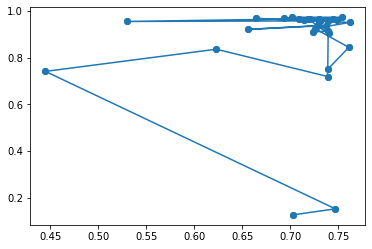

In [37]:
plt.scatter(x=result['CIFAR'].tolist(), y=result['MNIST'].tolist())
plt.plot(result['CIFAR'].tolist(), result['MNIST'].tolist(), '-o')
plt.show()


In [35]:
plt.scatter()

<function matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=<deprecated parameter>, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)>